# 📊 Proyecto Final: Predicción de Churn (Telco)

**Objetivo:** Predecir si un cliente cancelará el servicio.
**Estrategia:** Comparar Regresión Logística vs KNN.
**Metodología:** Veremos paso a paso cómo se transforman los datos crudos hasta convertirse en predicciones.

In [2]:
# 1. Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y Preprocesamiento
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)

sns.set_style('whitegrid')
%matplotlib inline

## 2. Exploración de Datos Crudos (Raw Data)
Cargamos el archivo tal cual viene de la fuente.

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"Dimensiones Originales: {df.shape}")
print("\n--- Primeras 5 filas (Datos Crudos) ---")
display(df.head())

Dimensiones Originales: (7043, 21)

--- Primeras 5 filas (Datos Crudos) ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Limpieza de Datos (Paso a Paso)

### 3.1 Corrección de Tipos de Datos
La columna `TotalCharges` debería ser numérica, pero pandas la leyó como texto. Esto suele indicar caracteres ocultos (espacios vacíos).

In [4]:
# Intentamos convertir a numérico, forzando errores a NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificamos cuántos datos se perdieron (eran espacios vacíos)
nulos = df['TotalCharges'].isnull().sum()
print(f"Se encontraron {nulos} valores nulos en TotalCharges después de la corrección.")

Se encontraron 11 valores nulos en TotalCharges después de la corrección.


### 3.2 Eliminación de Ruido
Eliminamos los nulos encontrados y la columna `customerID` que no sirve para predecir.

In [5]:
# Eliminamos nulos
df.dropna(inplace=True)

# Eliminamos ID
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convertimos el Target a 0 y 1 visualmente
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("--- Dataset Limpio (Sin ID y sin Nulos) ---")
display(df.head())

--- Dataset Limpio (Sin ID y sin Nulos) ---


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 4. Ingeniería de Características (Feature Engineering)

### 4.1 One-Hot Encoding (Transformación de Texto a Números)
Los modelos no entienden "Fiber Optic" o "Electronic Check". Creamos columnas binarias para cada opción.
Observa cómo aumenta el número de columnas.

In [6]:
# Guardamos las variables numéricas aparte para no tocarlas en este paso
X = df.drop('Churn', axis=1)
y = df['Churn']

categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Columnas Categóricas a transformar: {list(categorical_cols)}")

# Aplicamos One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"\nDimensiones antes: {X.shape} -> Dimensiones después: {X_encoded.shape}")
print("\n--- Así se ven los datos ahora (Nuevas columnas agregadas) ---")
display(X_encoded.iloc[:, -5:].head()) # Mostramos solo las últimas 5 columnas creadas

Columnas Categóricas a transformar: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Dimensiones antes: (7032, 19) -> Dimensiones después: (7032, 30)

--- Así se ven los datos ahora (Nuevas columnas agregadas) ---


,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,False,True,False,True,False
1,False,False,False,False,True
2,False,True,False,False,True
3,False,False,False,False,False
4,False,True,False,True,False


### 4.2 Escalado de Datos (MinMax Scaling)
Variables como `tenure` (meses) van de 0 a 72, mientras que `TotalCharges` llega a miles. Esto confunde a KNN.
Vamos a comprimir todo al rango [0, 1].

In [7]:
numerical_cols = X_encoded.select_dtypes(include=['int64', 'float64']).columns

# Mostramos un ejemplo antes del escalado
print("Ejemplo de 'TotalCharges' ANTES del escalado:")
print(X_encoded['TotalCharges'].head(3).values)

# Escalamos
scaler = MinMaxScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# Mostramos después
print("\nEjemplo de 'TotalCharges' DESPUÉS del escalado (Todo entre 0 y 1):")
print(X_encoded['TotalCharges'].head(3).values)

Ejemplo de 'TotalCharges' ANTES del escalado:
[  29.85 1889.5   108.15]

Ejemplo de 'TotalCharges' DESPUÉS del escalado (Todo entre 0 y 1):
[0.0012751  0.21586661 0.01031041]


## 5. División de Datos (Train/Test Split)
Separamos el 80% para enseñar al modelo y guardamos el 20% oculto para el examen final.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f"Datos para Entrenar (Train): {X_train.shape}")
print(f"Datos para Evaluar (Test): {X_test.shape}")

Datos para Entrenar (Train): (5625, 30)
Datos para Evaluar (Test): (1407, 30)


## 6. Modelado y Resultados

### 6.1 Regresión Logística

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



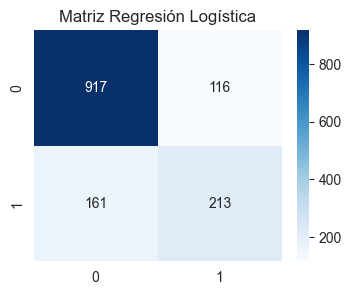

In [9]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz Regresión Logística')
plt.show()

### 6.2 K-Nearest Neighbors (KNN)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.56      0.56      0.56       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



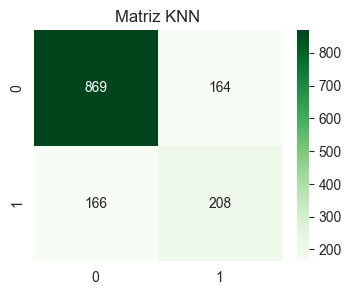

In [10]:
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_knn))

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz KNN')
plt.show()

## 7. Comparación Final (ROC Curve)

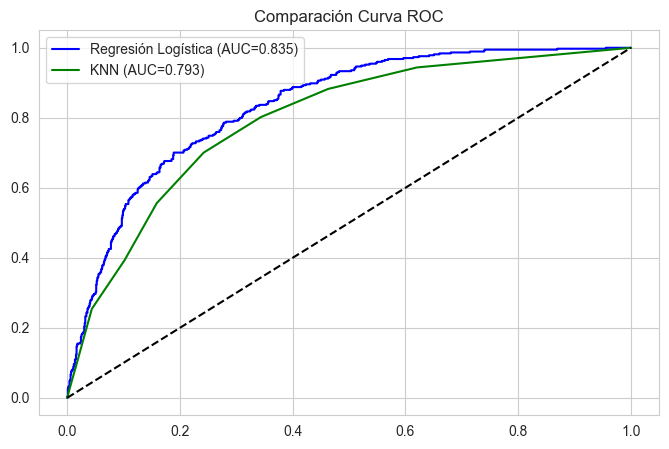

In [11]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
auc_knn = roc_auc_score(y_test, y_prob_knn)

plt.figure(figsize=(8, 5))
plt.plot(fpr_log, tpr_log, label=f'Regresión Logística (AUC={auc_log:.3f})', color='blue')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC={auc_knn:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Comparación Curva ROC')
plt.legend()
plt.show()